In [353]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from scipy import stats

print("All libraries have been successfully imported.")

All libraries have been successfully imported.


In [354]:
#load data into a df
gallstone_df = pd.read_excel('/Users/tmccarty/Desktop/sauce/DA projects/gallstone machine learning project/gallstone_data.xlsx')
print("The data has been successfully loaded.")
gallstone_df.head()



The data has been successfully loaded.


,Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,0,0,0,0,0,185,92.8,...,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
1,0,47,0,1,0,0,0,0,176,94.5,...,43.0,103.0,14.0,13.0,46.0,0.87,107.10,0.0,14.4,25.0
2,0,61,0,0,0,0,0,0,171,91.1,...,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,0,0,0,0,0,168,67.7,...,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,0,0,0,0,0,178,89.6,...,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6


In [355]:
#check for missing data
missing_count = gallstone_df.isnull().sum().sum()
missing_percent = missing_count/ (gallstone_df.shape[0] * gallstone_df.shape[1])*100

if missing_count == 0:
    print("There are no missing values in the dataset")
else:
    print(f"WARNING: There are {missing_count} missing value(s)."
          f"This missing data represents {missing_percent:.2f}% of the data.")


There are no missing values in the dataset


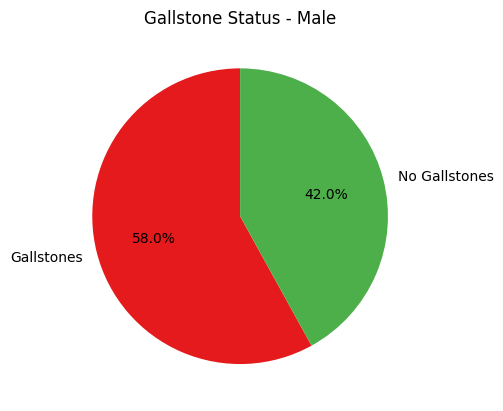

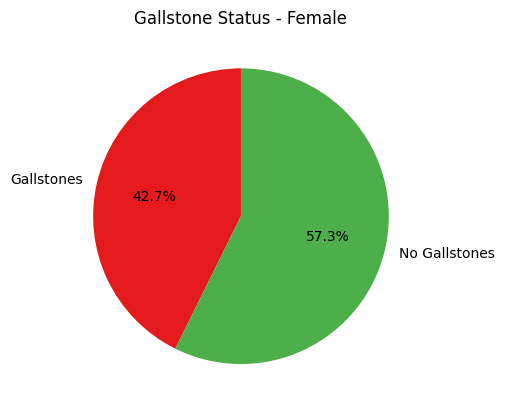

In [356]:
#Q1. Are there equal number of M/F in this study? 
grouped = (
    gallstone_df.groupby(["Gender", "Gallstone Status"]).size().unstack()
)

labels = ['Gallstones', 'No Gallstones']

#because genders are coded, need to uncode them for better visualization
gender_labels = {0: "Male", 1: "Female"}


for gender in grouped.index: 
    plt.figure()
    plt.pie(
        grouped.loc[gender],
        labels= labels, 
        startangle= 90,
        autopct='%1.1f%%', 
        colors= ["#e41a1c", "#4daf4a"]
    )
    plt.title (f'Gallstone Status - {gender_labels[gender]}')
    plt.show()

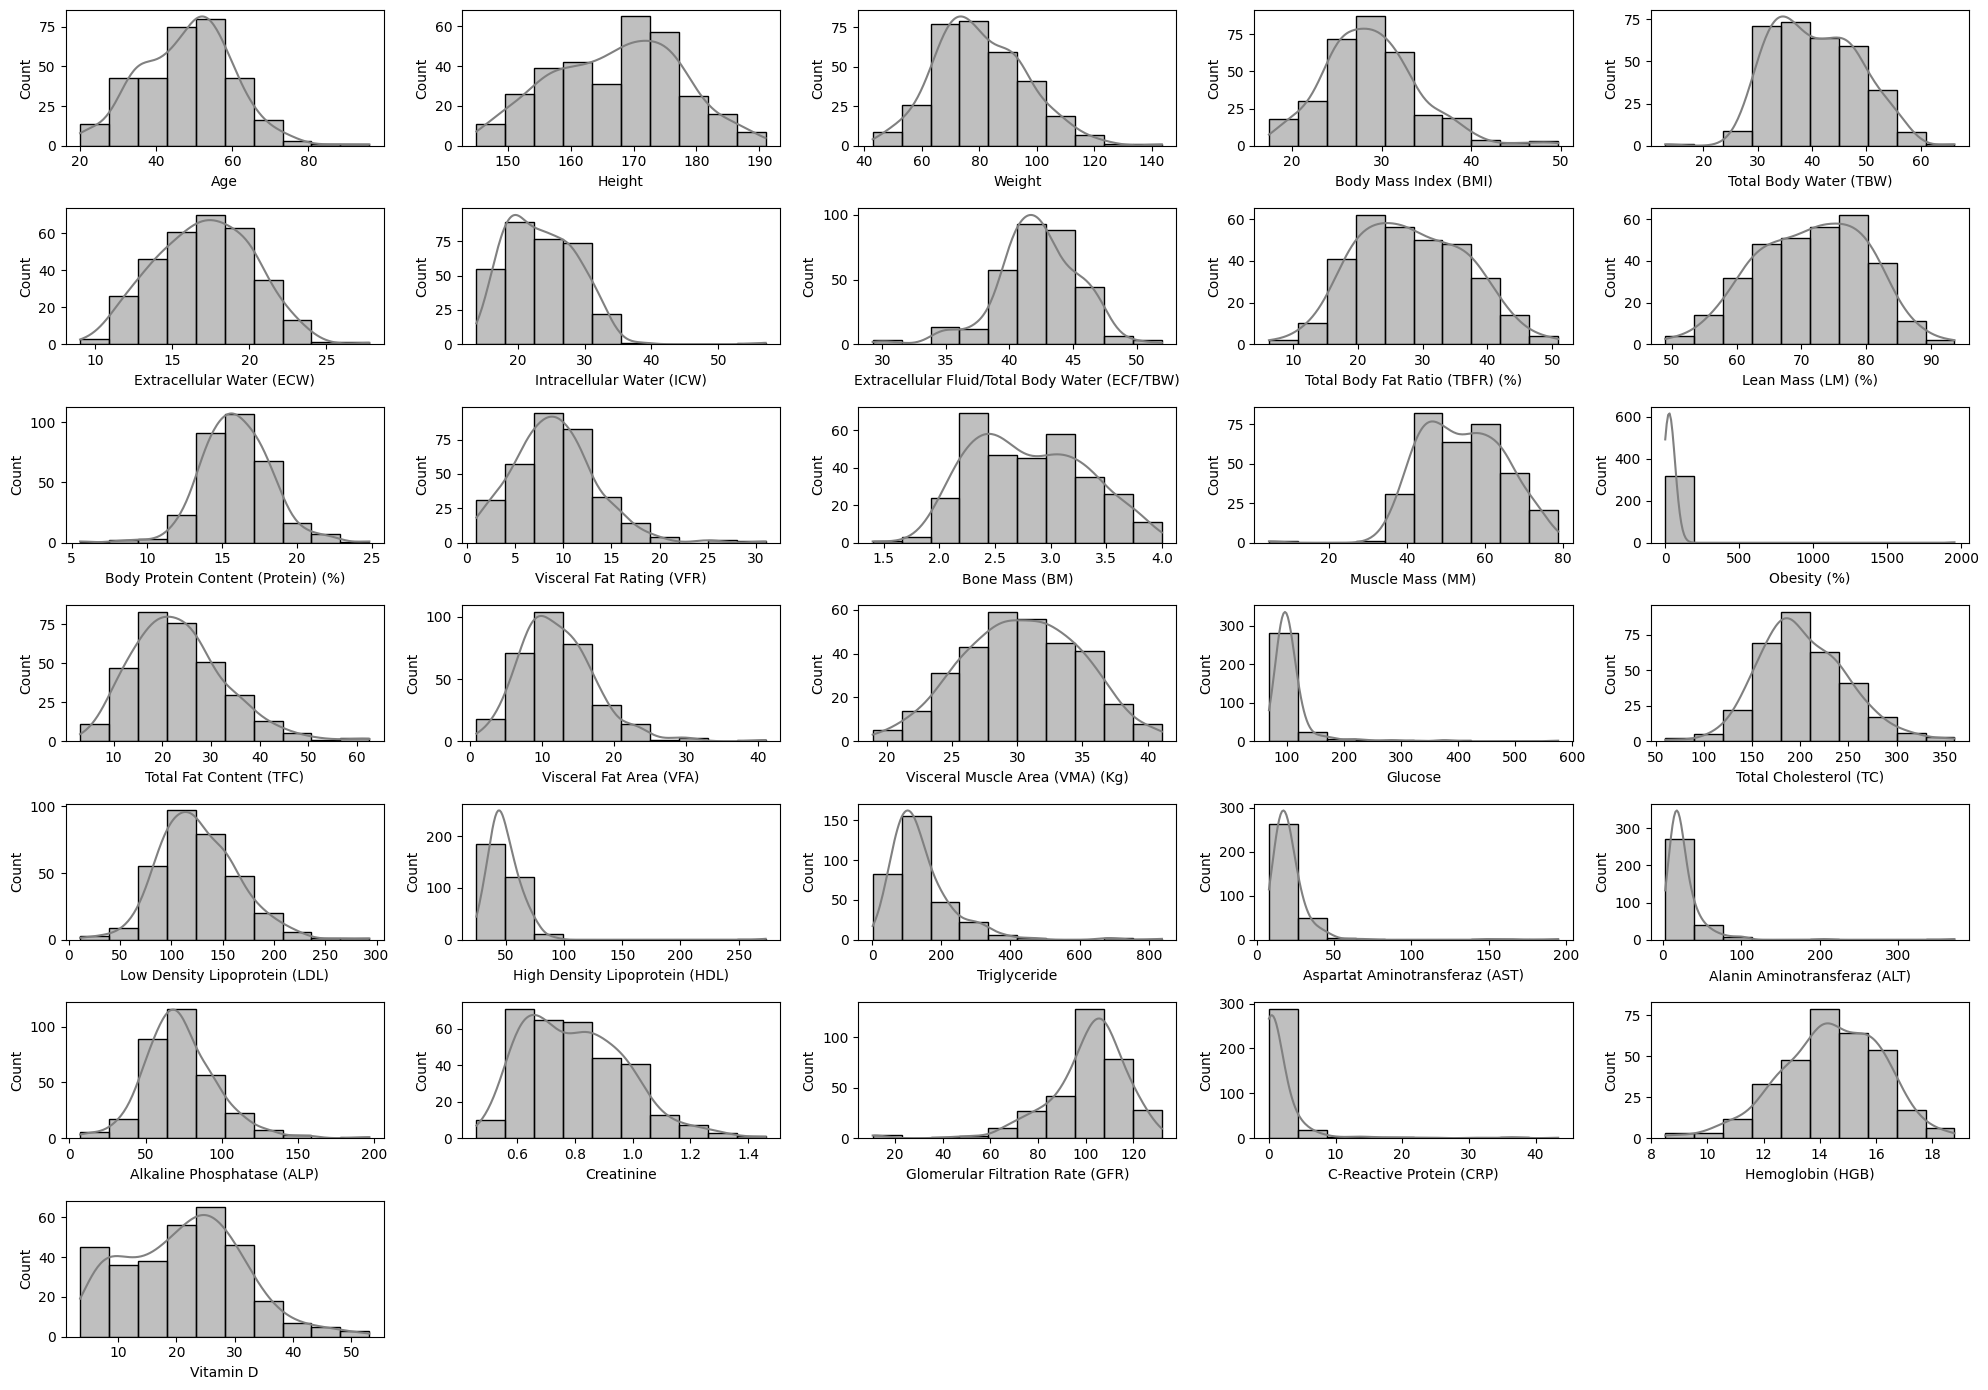

In [357]:
#Visualizing the data trends
cont_cols = [
col for col in gallstone_df.select_dtypes(include= ['int', 'float']).columns if gallstone_df[col].nunique() >5]

n = len(cont_cols) #number of features
cols = 5
rows = (n + cols - 1) // cols

fig, ax = plt.subplots(rows, cols, figsize=(20, 2*rows))
ax = ax.flatten()

for i, col in enumerate(cont_cols): 
    sns.histplot(gallstone_df[col],
                 bins= 10,
                 kde= True, 
                 ax = ax[i], 
                 color = 'gray')
    
for j in range(i+1, len(ax)): 
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [358]:
# Logistic regression model set up
#using a random seed value for reproducibility
rs = 44

patient_features = gallstone_df.drop("Gallstone Status",axis=1).values
gallstone_risk = gallstone_df["Gallstone Status"].values

patient_features_train, patient_features_test, gallstone_risk_train, gallstone_risk_test = train_test_split(patient_features, gallstone_risk, test_size= 0.3, random_state = rs, stratify=gallstone_risk)

#Scaling
scaler = StandardScaler()
patient_features_train_scaled = scaler.fit_transform(patient_features_train)
patient_features_test_scaled = scaler.transform(patient_features_test)

logreg = LogisticRegression()

logreg.fit(patient_features_train_scaled, gallstone_risk_train)
lg_gallstone_probabilites = logreg.predict_proba(patient_features_test_scaled)[:,1] #positive class

#Thresholding
threshold = 0.65
lg_predicted_labels = (lg_gallstone_probabilites >= threshold).astype(int)

#Model evaluation
metrics = {
    "precision" : precision_score(gallstone_risk_test, lg_predicted_labels),
    "recall" : recall_score(gallstone_risk_test, lg_predicted_labels),
    "f1": f1_score(gallstone_risk_test, lg_predicted_labels),
    "auc" :roc_auc_score(gallstone_risk_test, lg_gallstone_probabilites)
}

# Convert to DataFrame for display
metrics_df = pd.DataFrame(metrics, index=[0]).T.rename(columns={0: 'LG Score'})
print(metrics_df)


           LG Score
precision  0.794872
recall     0.645833
f1         0.712644
auc        0.817274


In [359]:
#To assess whether a more flexible, non-linear approach yields comparable or improved performance,a Random Forest classifier is trained using the same feature set.

#Random Forest Classifier Set Up
rf = RandomForestClassifier(n_estimators=100,
                           min_samples_leaf = 2,
                           max_depth= None,
                           n_jobs = -1,
                           min_samples_split=2,
                           random_state=rs)

print("The model has been successfully initiated...")


rf.fit(patient_features_train, gallstone_risk_train) 

print("The model has been trained successfully.")


rf_gallstone_probabilites = rf.predict_proba(patient_features_test)[:,1] #positive class
rf_predicted_labels = (rf_gallstone_probabilites >= threshold).astype(int) #Holding threshold constant for both models for a true comparison

print("Model predictions have been made successfully.")

#Model evaluation
metrics = {
    "precision" : precision_score(gallstone_risk_test, rf_predicted_labels),
    "recall" : recall_score(gallstone_risk_test, rf_predicted_labels),
    "f1": f1_score(gallstone_risk_test, rf_predicted_labels),
    "auc" :roc_auc_score(gallstone_risk_test, rf_gallstone_probabilites)
}

print("Model evalulation completed successfully.")


The model has been successfully initiated...
The model has been trained successfully.
Model predictions have been made successfully.
Model evalulation completed successfully.


In [360]:
#comparisons between logistic regression and random forest models
rf_metrics_df = pd.DataFrame(metrics, index=[0]).T.rename(columns={0: 'RF Score'})

metrics_df = metrics_df.join(rf_metrics_df)

print("The comparison bewteen logistic regression and random forest:")
print(metrics_df)

The comparison bewteen logistic regression and random forest:
           LG Score  RF Score
precision  0.794872  0.962963
recall     0.645833  0.541667
f1         0.712644  0.693333
auc        0.817274  0.863281


In [365]:
#Statistical Feature Importance (F Score) and LG coeffients

feature_names = gallstone_df.drop("Gallstone Status", axis=1).columns 
f_scores, p_values = f_classif(patient_features, gallstone_risk) 

anova_df = pd.DataFrame({'Feature': feature_names, 'F Score':f_scores, 'LG Coef': logreg.coef_[0]}).sort_values('F Score', ascending=False)

print(anova_df)

                                           Feature    F Score   LG Coef
37                                       Vitamin D  45.673154 -0.945935
35                        C-Reactive Protein (CRP)  27.385949  0.937753
15                              Lean Mass (LM) (%)  17.022706 -0.548533
14                 Total Body Fat Ratio (TBFR) (%)  16.978389  0.712772
18                                  Bone Mass (BM)  15.599719 -1.582229
36                                Hemoglobin (HGB)  12.781941 -0.568199
11                       Extracellular Water (ECW)  10.425070 -0.311177
21                         Total Fat Content (TFC)   9.451995 -0.609826
13  Extracellular Fluid/Total Body Water (ECF/TBW)   9.414047 -0.752643
5                                   Hyperlipidemia   8.532832  0.793341
28                  High Density Lipoprotein (HDL)   8.181862  0.423065
1                                           Gender   7.647763 -0.881835
22                         Visceral Fat Area (VFA)   6.374108  0

<Figure size 800x2000 with 0 Axes>

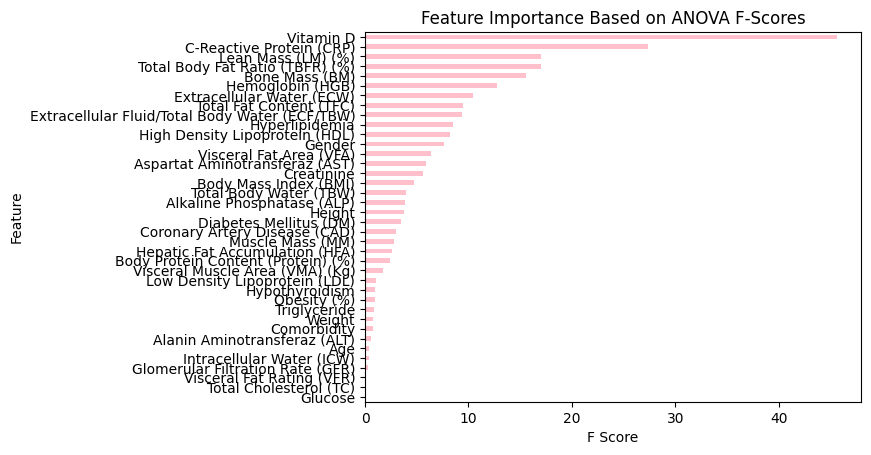

In [ ]:
#Visualizing F-Scores vs. Features

plt.figure(figsize=(8,20)) 

anova_df.sort_values("F Score", ascending= True).plot(x= "Feature", y= "F Score", kind='barh', color='pink', legend = False)

plt.title("Feature Importance Based on ANOVA F-Scores")
plt.xlabel("F Score")
plt.show()

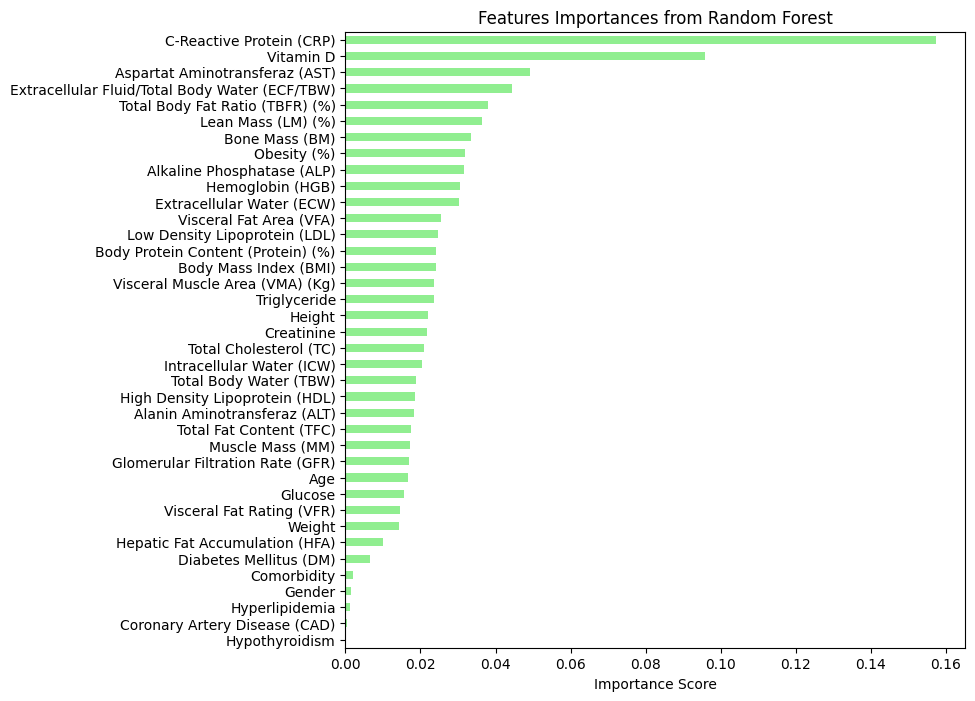

In [ ]:
#Visualizing Feature Importance in RF model

importances = pd.Series(data=rf.feature_importances_,index=gallstone_df.drop("Gallstone Status", axis=1).columns) 


importances_sorted = importances.sort_values() 
plt.figure(figsize=(8,8)) 


importances_sorted.plot(kind='barh', color='lightgreen') 
plt.title('Features Importances from Random Forest') 
plt.xlabel("Importance Score")
plt.show() 

/var/folders/_8/zgrl9yjd2pb1p_czpyy24_4h0000gn/T/ipykernel_71968/91751920.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_8/zgrl9yjd2pb1p_czpyy24_4h0000gn/T/ipykernel_71968/91751920.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


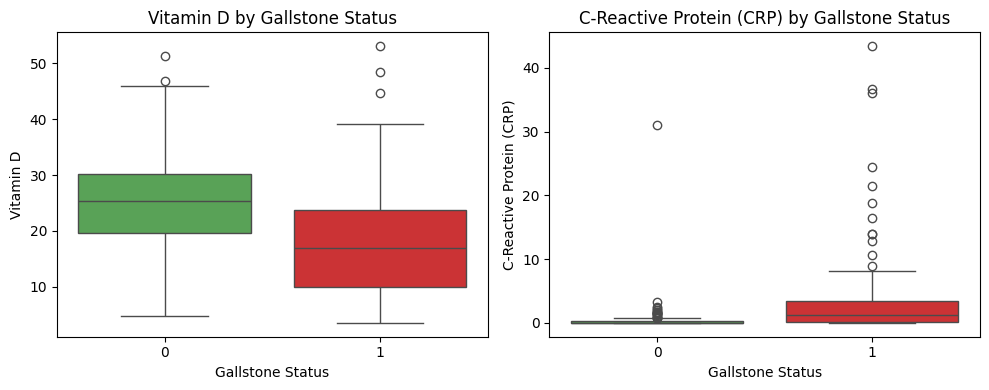

In [369]:
#Gallstone Status in highest ranked features from LG and RF models

colors = {"1": "#e41a1c", "0": "#4daf4a"} #color palette

features =["Vitamin D", "C-Reactive Protein (CRP)"]
fig, axes = plt.subplots(1, len(features), figsize=(5 * len(features), 4))

for ax, feature in zip(axes, features):
    sns.boxplot(
        data=gallstone_df,
        x="Gallstone Status",
        y=feature,
        palette=colors,
        ax=ax
    )
    ax.set_title(f"{feature} by Gallstone Status")

plt.tight_layout()
plt.show()